# HIO Algorithm for Phase Retrieval

## Introduction
This notebook implements the **Hybrid Input-Output (HIO) Algorithm** for iterative phase retrieval. The goal is to reconstruct an image using only its Fourier magnitude while imposing real-space constraints. This approach is widely used in **optical imaging, X-ray crystallography, and astronomy**.

The algorithm works as follows:
- Compute the **Fourier transform** of a known image.
- Retain only the **magnitude information** and discard the phase.
- Use an iterative approach to **recover the phase** by enforcing constraints in both Fourier and spatial domains.

This method is particularly useful in **lensless imaging** applications where the phase of the optical wavefront is lost.

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.fft import fft2, ifft2
import os


## Loading and Preprocessing the Image

A test image is loaded, converted to grayscale, and **zero-padded** to simulate an extended support region. This ensures that the Fourier transform does not introduce artificial boundaries that affect phase retrieval.


In [207]:
# Read in source image
source = Image.open(r'C:\Users\asus\Desktop\Image manipulation\Lena.png').convert("L")

# Get image dimensions
width, height = source.size

# Pad image to simulate oversampling
pad_len = max(width, height)
padded = np.pad(np.array(source), ((pad_len, pad_len), (pad_len, pad_len)), 'constant')

## Computing Fourier Magnitude

The **Fourier Transform (FT)** of the padded image is computed using the Fast Fourier Transform (FFT). Since phase information is missing in certain imaging techniques, we retain only the **Fourier magnitude** (absolute values of the FFT).


In [209]:
ft = fft2(padded)

# Simulate diffraction pattern
diffract = np.abs(ft)

## Defining the Image Region Mask

A **binary mask** is created to differentiate the object region from the background in the reconstructed image. This mask will be used to apply constraints during iterative updates.

In [211]:
l = len(padded)

# Create mask for image region
mask = np.zeros_like(padded, dtype=bool)
mask[pad_len:pad_len + height, pad_len:pad_len + width] = True


## Initializing with a Random Phase

Since phase information is unavailable, we generate an **initial guess** by combining the measured Fourier magnitude with a **random phase distribution**.

In [213]:
# Initial guess using random phase
guess = diffract * np.exp(1j * np.random.rand(l, l) * 2 * np.pi)


## **Algorithm Implementation**  

The reconstruction process follows an iterative approach, where an initial estimate undergoes continuous refinement over **501 iterations**. The steps involved are detailed below:

### **1. Initialization**  
- The variable `prev` is initialized as a zero-valued array of the same shape as the padded image.
- The number of iterations, `r`, is set to **501**.
- A step-size parameter `β = 0.8` is chosen to control the update rate.

### **2. Iterative Phase Retrieval Process**  

At each iteration, the algorithm applies constraints in both **Fourier space** and **real space** to refine the image estimate.

#### **Fourier Domain Constraint:**  
- The Fourier amplitude of the estimate is replaced with the known diffraction amplitude (`diffract`), while preserving the phase from the previous iteration. This results in a new estimate:  

  $$
  \text{update} = \text{diffract} \cdot e^{i \cdot \theta}
  $$

  where $ \theta $ is the phase from the previous estimate.  
- The inverse Fourier transform (`ifft2(update)`) is computed to bring the estimate back into the real domain.

#### **Real-Space Constraint:**  
- The recovered real-space image is refined using **non-negativity and support constraints** as follows:  
  - Pixels within the object region (`mask`) that have **negative values** are modified using:

    $$
    \text{inv}[\text{neg_mask}] = \text{prev}[\text{neg_mask}] - \beta \cdot \text{inv}[\text{neg_mask}]
    $$
    
This ensures that the recovered image respects non-negativity constraints, which is essential in phase retrieval problems where intensity values should be positive or zero. 

  - Pixels **outside the object region** are similarly updated:

    $$
    \text{inv}[\text{support_mask}] = \text{prev}[\text{support_mask}] - \beta \cdot \text{inv}[\text{support_mask}]
    $$
    
The term $ \beta \cdot \text{inv}[\text{support_mask}] $ acts as a damping factor, reducing the magnitude of values outside the support.
Over iterations, this gradually pushes unwanted artifacts toward zero. This step thus improves reconstruction accuracy by ensuring that the algorithm does not introduce artifacts where the object should not exist.

  These steps ensures that the reconstructed image satisfies both **non-negativity** and **support constraints**.

#### **Iteration Update:**  
- The updated image replaces the previous estimate (`prev = inv.copy()`).
- The **Fourier transform** (`fft2(inv)`) is computed to update the phase information.

### **3. Saving Progress**  
To visualize the reconstruction process, the algorithm saves the intermediate results every **100 iterations**. The saved images are normalized to grayscale (0–255) and stored in `save_dir`.  

$$
\text{Image} = \frac{\text{prev} - \min(\text{prev})}{\max(\text{prev}) - \min(\text{prev})} \times 255
$$

These saved images help track how the reconstruction improves over time.


In [215]:
save_dir = r"C:\Users\asus\Desktop\Image manipulation\save5"
os.makedirs(save_dir, exist_ok=True)

# Number of iterations
r = 501

# Step size parameter
beta = 0.8

# Previous result
prev = np.zeros_like(padded, dtype=float)

for s in range(r):
    # Fourier domain constraints
    update = diffract * np.exp(1j * np.angle(guess))
    inv = np.real(ifft2(update))
    
    # Apply real-space constraints using vectorized operations
    neg_mask = (inv < 0) & mask  # Negative values in the image region
    support_mask = ~mask         # Outside the image region
    
    inv[neg_mask] = prev[neg_mask] - beta * inv[neg_mask]
    inv[support_mask] = prev[support_mask] - beta * inv[support_mask]
    
    prev = inv.copy()
    guess = fft2(inv)

    # Save progress every 100 iterations
    if s % 100 == 0:
        Image.fromarray((prev - prev.min()) / (prev.max() - prev.min()) * 255).convert("L").save(os.path.join(save_dir, f"progress{s}.png"))
        print(f"Iteration {s} saved.")


Iteration 0 saved.
Iteration 100 saved.
Iteration 200 saved.
Iteration 300 saved.
Iteration 400 saved.
Iteration 500 saved.


The saved images are shown below for reference

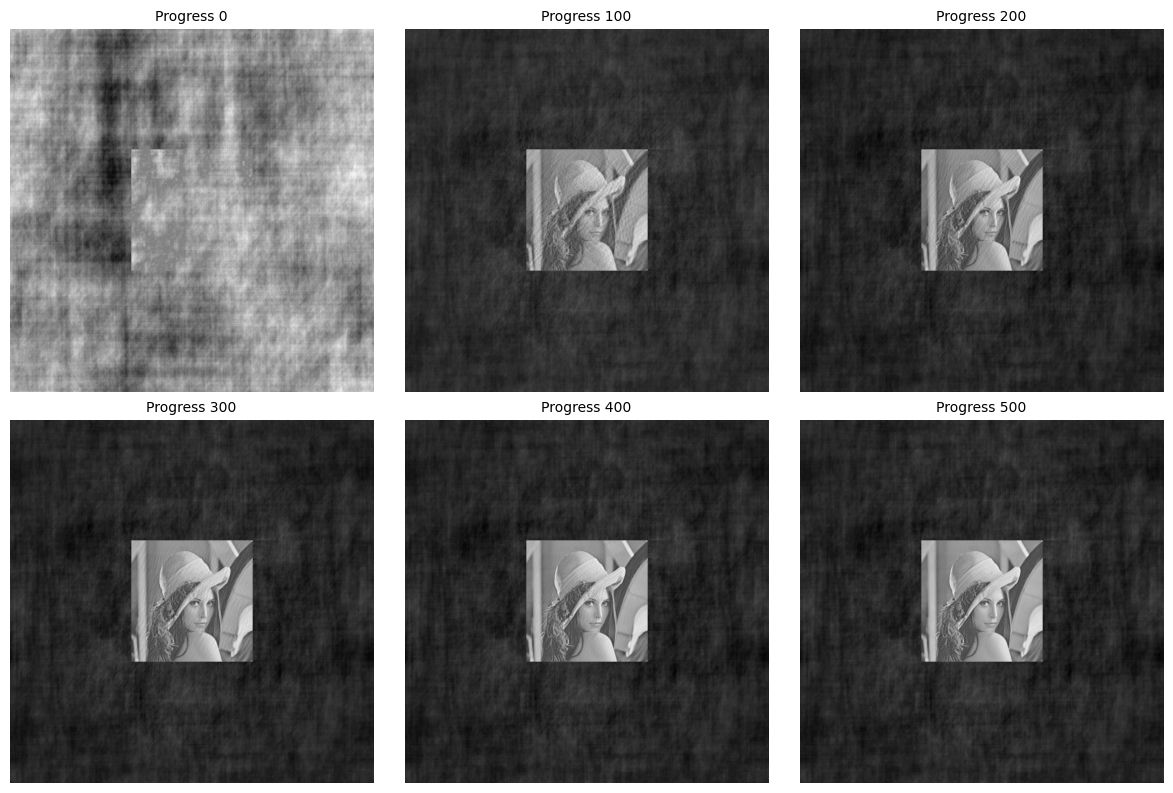

In [217]:
# List of progress image filenames
image_indices = range(0, 501, 100)  # 0, 100, 200, ..., 500

# Define grid dimensions (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjust size as needed

for ax, i in zip(axes.flat, image_indices):  # Flatten axes array for easy iteration
    img_path = os.path.join(save_dir, f"progress{i}.png")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Progress {i}", fontsize=10)
        ax.axis("off")  # Hide axes for cleaner visualization
    else:
        ax.axis("off")  # Hide empty plots if file is missing

plt.tight_layout()
plt.show() 


## Computing the Difference Image

To assess reconstruction accuracy, the **difference between the recovered image and the original image** is computed and saved.


In [219]:
# Compute difference between recovered image and padded original
difference = padded - prev

# Save difference image
Image.fromarray((difference - difference.min()) / (difference.max() - difference.min()) * 255).convert("L").save(os.path.join(save_dir, "difference.png"))
print("Difference image saved.")

Difference image saved.


The difference image is added too for reference. 


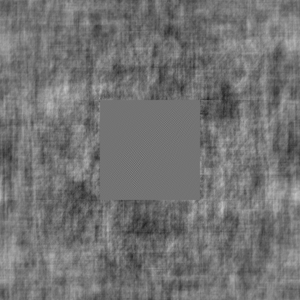

In [269]:
save_dir = r"C:\Users\asus\Desktop\Image manipulation\save5"
# Load the saved difference image
diff_image_path = os.path.join(save_dir, "difference.png")
diff_image = Image.open(diff_image_path)

display(diff_image.resize((300, 300)))

### **Analysis of the Difference Image**  

The difference image represents the residual error between the original (padded) image and the reconstructed image obtained using the algorithm. The central region retains structural information, indicating that the algorithm successfully recovered major features of the object. Some high-frequency details and edges are visible, suggesting that the reconstruction preserves key elements despite phase ambiguity. The surrounding noise-like artifacts mainly appear in the padded regions, which do not contribute to the actual object reconstruction. Overall, the phase retrieval process demonstrates effective image recovery, with potential for further refinement through additional iterations or even better constraints.  


## Visualization of Results

The **original padded image** and the **recovered image** are displayed side by side for comparison.

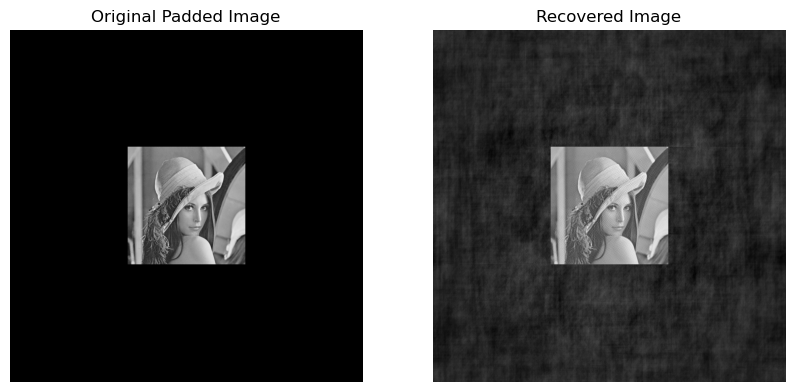

In [224]:
plane_reconstruction = prev.copy()  # Save result for comparison later
# Plot original and final images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(padded, cmap='gray')
ax[0].set_title("Original Padded Image")
ax[0].axis("off")

prev_copy = prev.copy()
prev_normalized = (prev_copy - prev_copy.min()) / (prev_copy.max() - prev_copy.min()) * 255
ax[1].imshow(prev_normalized.astype(np.uint8), cmap='gray')
ax[1].set_title("Recovered Image")
ax[1].axis("off")
plt.show()


Thus, our algorithm is able to reconstruct the original image with all significant features identifiable, within a few hundred iterations.

To have a better look at the reconstructuion, let's remove the padding and get the images side by side.

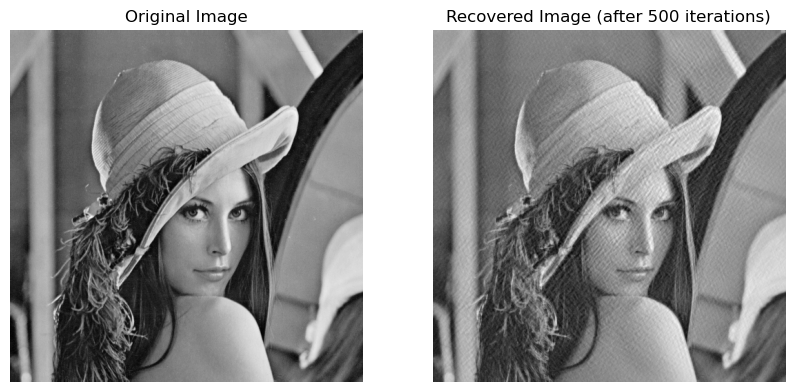

In [226]:
# Plot original and reconstructed images side by side (without padding)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Show the original image
ax[0].imshow(source, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

# Crop the reconstructed image to match the original dimensions
recovered_cropped = prev[pad_len:pad_len + height, pad_len:pad_len + width]
recovered_normalized = (recovered_cropped - recovered_cropped.min()) / (recovered_cropped.max() - recovered_cropped.min()) * 255

# Show the reconstructed image without padding
ax[1].imshow(recovered_normalized.astype(np.uint8), cmap='gray')
ax[1].set_title("Recovered Image (after 500 iterations)")
ax[1].axis("off")

plt.show()



The **Hybrid Input-Output (HIO) Algorithm** effectively reconstructs an image by iteratively refining the phase information. Despite some artifacts, the recovered image closely resembles the original, within a few hundred iterations.

This method is widely used in applications such as:
- **Lensless imaging and holography**
- **X-ray crystallography**
- **Astronomical imaging (e.g., wavefront sensing)**

Further improvements can be made by using **alternative phase retrieval algorithms**, or incorporating **deep learning techniques** for faster convergence. One method to mitigate stagnation problems like twin image is to use an different illumination for the object at hand. Here, we discuss votex illumination and show how it reconstructs the image more efficiently in fewer number of iterations comapred to plane illumination, in addition to mitigating stagnation effects.

# Vortex Illumination Reconstruction Using HIO Algorithm

In this section, we implement **iterative phase retrieval** using the **Hybrid Input-Output (HIO) algorithm**.  
Instead of **plane illumination**, we now use a **vortex phase illumination** defined as:

$$
\theta(x, y) = \arctan{\left(\frac{y}{x}\right)}
$$

This introduces a **spatial phase variation** that alters the diffraction pattern, making phase retrieval more complex, however more rewarding.
For this, we reconstruct the image and then analyze the difference between the original and retrieved images.

For this, the image is first loaded and padded and a save directory is created, as before.

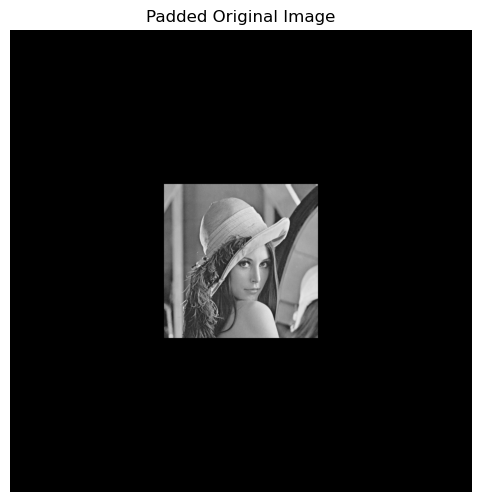

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.fft import fft2, ifft2
import os
# Read source image
source = Image.open(r'C:\Users\asus\Desktop\Image manipulation\Lena.png').convert("L")

# Get image dimensions
width, height = source.size

# Pad image to simulate oversampling
pad_len = max(width, height)
padded = np.pad(np.array(source), ((pad_len, pad_len), (pad_len, pad_len)), 'constant')

# Create mask for image region
mask = np.zeros_like(padded, dtype=bool)
mask[pad_len:pad_len + height, pad_len:pad_len + width] = True

# Create directory for saving results
save_dir = r"C:\Users\asus\Desktop\Image manipulation\save_vortex1"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(6, 6))
plt.imshow(padded, cmap='gray')
plt.title("Padded Original Image")
plt.axis("off")
plt.show()


## Vortex Phase Pattern

We apply **vortex illumination** by introducing a **phase mask** using the equation:

$$
\theta(x, y) = \arctan{\left(\frac{y}{x}\right)}
$$

The phase mask is applied to the original image to alter its Fourier domain properties, influencing the reconstructed image. 
istics.


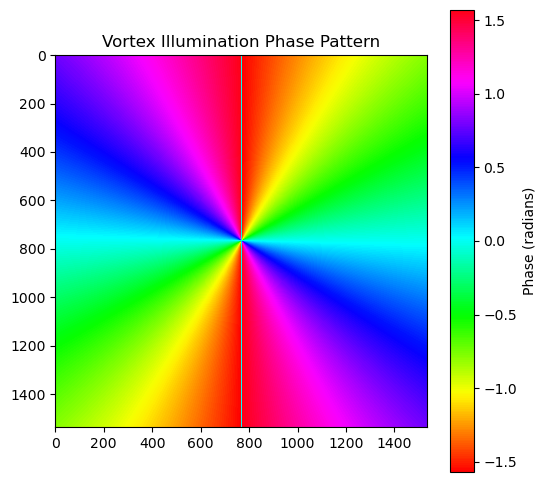

In [231]:
# Function to create vortex phase pattern
def create_vortex_phase(shape):
    y, x = np.indices(shape)
    y = y - shape[0] // 2
    x = x - shape[1] // 2
    
    # Avoid division by zero
    epsilon = 1e-10
    safe_x = np.where(np.abs(x) < epsilon, epsilon, x)
    
    # Use arctan(y/x)
    angle = np.arctan(y / safe_x)
    return np.exp(1j * angle)

# Create vortex phase
vortex_phase = create_vortex_phase(padded.shape)

# Apply vortex illumination
object_with_vortex = padded * vortex_phase

# Display vortex phase pattern
plt.figure(figsize=(6, 6))
plt.imshow(np.angle(vortex_phase), cmap='hsv')
plt.colorbar(label="Phase (radians)")
plt.title("Vortex Illumination Phase Pattern")
plt.savefig(os.path.join(save_dir, "vortex_phase.png"))
plt.show()


## HIO Algorithm Implementation

We apply the **Hybrid Input-Output (HIO) algorithm** to recover the lost phase information. The algorithm progresses as folleps:
1. Compute the **Fourier Transform** of the vortex-illuminated object.
2. Replace the amplitude with the known **diffraction pattern** while preserving phase.
3. Apply **Inverse Fourier Transform** to obtain an estimate.
4. Use the **support constraint** to refine the estimate.
5. Iterate the process to gradually recover the correct phase.

We set **β = 0.8** for the HIO update rule.


In [233]:
# Calculate diffraction pattern
ft = fft2(object_with_vortex)
diffract = np.abs(ft)

# Initial random phase guess
l = len(padded)
guess = diffract * np.exp(1j * np.random.rand(l, l) * 2 * np.pi)

# HIO parameters
iterations = 401
beta = 0.8
prev = np.zeros_like(padded, dtype=complex)

# Iterative Phase Retrieval
for s in range(iterations):
    update = diffract * np.exp(1j * np.angle(guess))
    inv = ifft2(update)
    
    # Remove vortex phase for constraint application
    inv_no_vortex = inv / vortex_phase
    real_part = np.real(inv_no_vortex)
    
    # Apply HIO constraints
    next_iteration = np.zeros_like(real_part, dtype=complex)
    positive_support = mask & (real_part >= 0)
    negative_support = mask & (real_part < 0)
    non_support = ~mask
    
    next_iteration[positive_support] = real_part[positive_support]
    next_iteration[negative_support] = np.real(prev[negative_support]) - beta * real_part[negative_support]
    next_iteration[non_support] = np.real(prev[non_support]) - beta * real_part[non_support]
    
    prev = next_iteration.copy()
    
    # Re-apply vortex phase
    next_with_vortex = next_iteration * vortex_phase
    guess = fft2(next_with_vortex)
    
    # Save progress images
    if s % 100 == 0 or s == iterations - 1:
        display_img = (real_part - real_part.min()) / (real_part.max() - real_part.min()) * 255
        Image.fromarray(display_img.astype(np.uint8)).convert("L").save(
            os.path.join(save_dir, f"vortex_progress_{s}.png"))
        print(f"Iteration {s} saved.")

# Final reconstructed image
final_result = np.real(prev)


Iteration 0 saved.
Iteration 100 saved.
Iteration 200 saved.
Iteration 300 saved.
Iteration 400 saved.


The saved images are shown for reference.

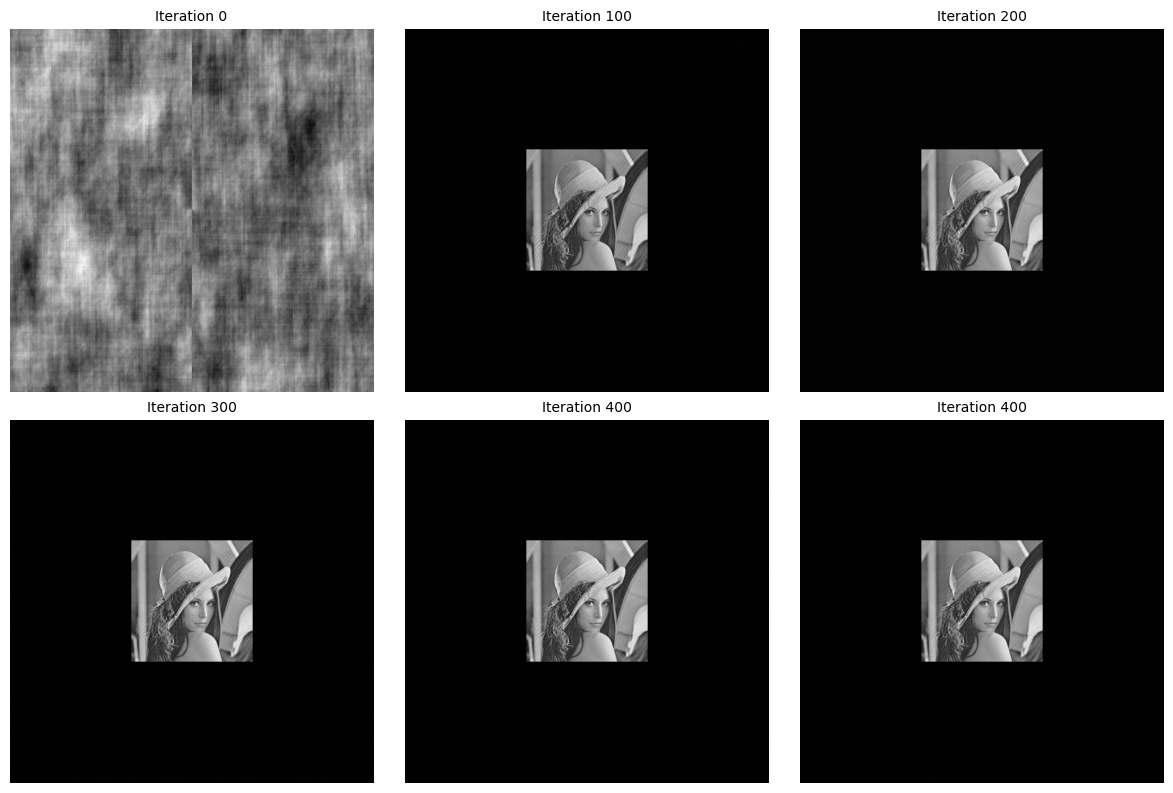

In [235]:
save_dir = r"C:\Users\asus\Desktop\Image manipulation\save_vortex1"
# List of saved progress images
image_indices = list(range(0, 401, 100)) + [400]  # Includes 0, 100, 200, 300, and 400

# Define grid dimensions (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjust figure size as needed

for ax, i in zip(axes.flat, image_indices):  # Flatten axes array for easy iteration
    img_path = os.path.join(save_dir, f"vortex_progress_{i}.png")
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Iteration {i}", fontsize=10)
        ax.axis("off")  # Hide axes for cleaner visualization
    else:
        ax.axis("off")  # Hide empty plots if file is missing

plt.tight_layout()
plt.show()


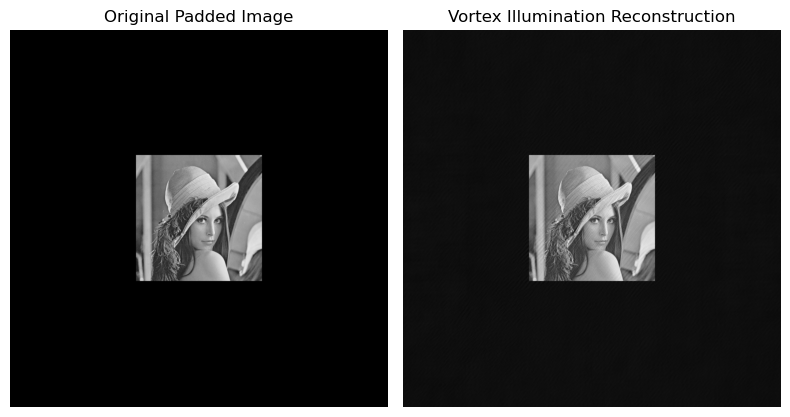

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

# Original Padded Image
ax[0].imshow(padded, cmap='gray')
ax[0].set_title("Original Padded Image")
ax[0].axis("off")

# Reconstructed Image
final_display = (final_result - final_result.min()) / (final_result.max() - final_result.min())
ax[1].imshow(final_display, cmap='gray')
ax[1].set_title("Vortex Illumination Reconstruction")
ax[1].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "vortex_final_comparison.png"))
plt.show()


The images are subtracted and the difference is obatained as outuput:

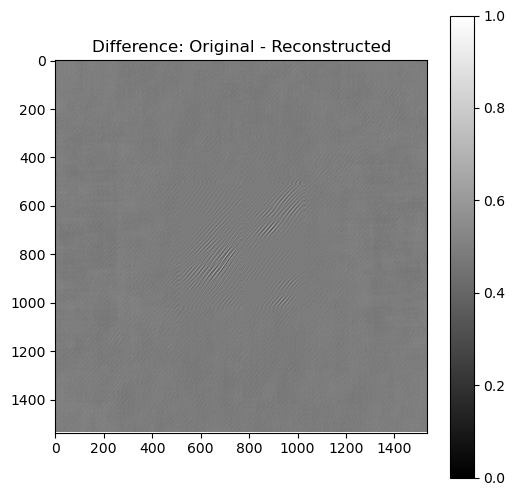

In [238]:
# Compute difference
difference = padded - final_result

plt.figure(figsize=(6, 6))
diff_norm = (difference - difference.min()) / (difference.max() - difference.min())
plt.imshow(diff_norm, cmap='gray')
plt.title("Difference: Original - Reconstructed")
plt.colorbar()
plt.savefig(os.path.join(save_dir, "vortex_difference.png"))
plt.show()


### Original vs. Reconstructed Image (Without Padding)
This section compares the original input image with the reconstructed image after iterative phase retrieval, **without any padding**.


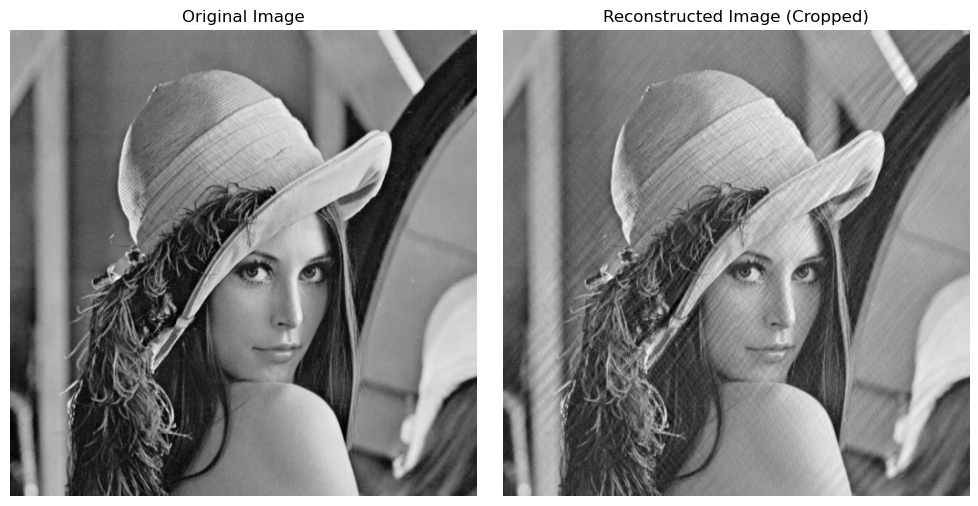

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# Crop the reconstructed image to match the original size
cropped_reconstructed = final_result[pad_len:pad_len + height, pad_len:pad_len + width]

# Plot original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(source, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Reconstructed image (cropped)
axes[1].imshow(cropped_reconstructed, cmap='gray')
axes[1].set_title("Reconstructed Image (Cropped)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


### Plane vs. Vortex Illumination Reconstruction
Here, we compare the reconstructed images obtained using **plane wave illumination** and **vortex illumination**.


C:\Users\asus\AppData\Local\Temp\ipykernel_18244\4186126807.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  axes[1].imshow(vortex_normalized.astype(np.uint8), cmap='gray')


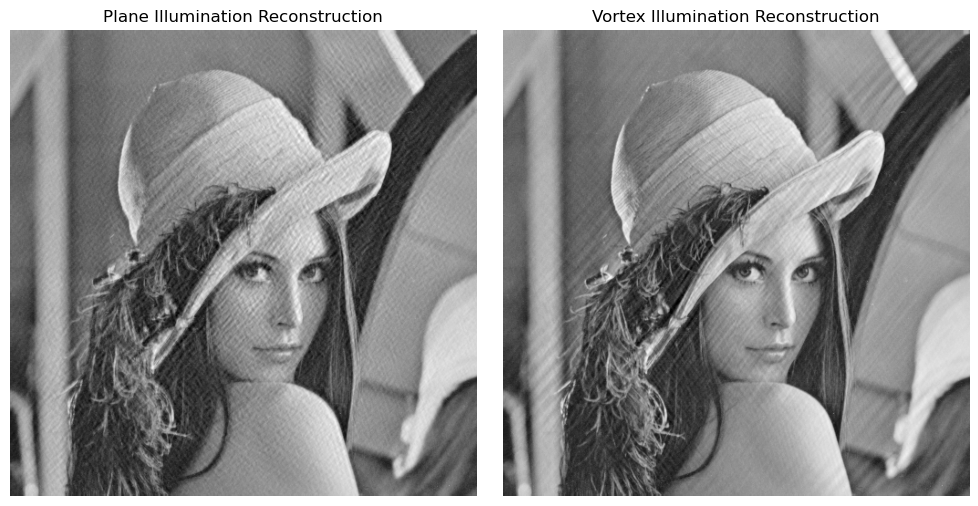

In [242]:
# Ensure that the plane reconstruction was stored separately before applying vortex illumination!
if 'plane_reconstruction' not in globals():
    raise ValueError("Plane reconstruction not stored before vortex illumination! Run plane HIO first.")

# Crop both reconstructions to original image size
cropped_plane = plane_reconstruction[pad_len:pad_len + height, pad_len:pad_len + width]
cropped_vortex = prev[pad_len:pad_len + height, pad_len:pad_len + width]  # prev now holds vortex reconstruction

# Normalize both images for display
plane_normalized = (cropped_plane - cropped_plane.min()) / (cropped_plane.max() - cropped_plane.min()) * 255
vortex_normalized = (cropped_vortex - cropped_vortex.min()) / (cropped_vortex.max() - cropped_vortex.min()) * 255

# Plot Plane vs. Vortex Reconstructions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plane Illumination Reconstruction
axes[0].imshow(plane_normalized.astype(np.uint8), cmap='gray')
axes[0].set_title("Plane Illumination Reconstruction")
axes[0].axis("off")

# Vortex Illumination Reconstruction
axes[1].imshow(vortex_normalized.astype(np.uint8), cmap='gray')
axes[1].set_title("Vortex Illumination Reconstruction")
axes[1].axis("off")

plt.tight_layout()
plt.show()




This comparison shows that vortex illumination achieves better reconstruction in fewer number of iterations, apart from helping avoid stagnation phenomena.